In [23]:
import datetime as dt
import pandas as pd
import numpy as np
from collections import OrderedDict

In [3]:
#read data set
df = pd.read_csv('SuperstoreTransaction.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [11]:
#convert object  to Datetime 
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

To perform customer segmentation, I decided to use recency, frequency, monetrary (RFM), and salesto do k-means clustering. And hopefully, we can cluster customers to low, medium, and high groups, representing the activity of each customer.

First, extract RFM features

In [17]:
#see the time range
print("Minimal Date=%s, Maximal Date=%s"%(min(df["Order Date"]).strftime("%Y-%m-%d"), \
                                          max(df["Order Date"]).strftime("%Y-%m-%d")))

Minimal Date=2014-01-03, Maximal Date=2017-12-30


The data is ranged from 2014-01-07 to 2018-01-05, we probably want to focuse on the most recent activities

In [48]:
#set up the inspection range
Start_Date_Obj = dt.datetime.strptime("12/10/2017", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("12/30/2017", "%m/%d/%Y")
Time_Window = 365 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 180 #days for frequency and monetary

In [49]:
#calculate RFM
check_point_date = Start_Date_Obj
UserID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []
while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
#     print(window_start)
    mask = (df["Order Date"] >= window_start) & (df["Order Date"] < check_point_date)
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = df.loc[mask]
#     print(data_checkpoint.head ())

    # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
    unique_users = list(set(data_checkpoint["Customer ID"]))
    print("There are %d unique users."%(len(unique_users)))
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
#     print(FM_Window_Start)
    
    for user in unique_users:
        UserID.append(user)
        Checkpoint.append(check_point_date)
        mask = data_checkpoint["Customer ID"] == user
        data_checkpoint_user = data_checkpoint.loc[mask]
        delta = check_point_date - max(data_checkpoint_user["Order Date"])
        recency = delta.days #Recency, days between checkpoint and last transaction time
        
        mask = data_checkpoint_user["Order Date"] >= FM_Window_Start
        data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
        frequency = data_checkpoint_user_fm.shape[0]
        value = np.sum(data_checkpoint_user_fm.iloc[:, -4]) #monetary values
        quantity = np.sum(data_checkpoint_user_fm.iloc[:, -3])#monetary quantity
        
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
    check_point_date = check_point_date + dt.timedelta(days = 1)

# Consolidate all columns into a signle data frame
RFM_Dict = OrderedDict([ ('Customer ID', UserID),
          ('Checkpoint', Checkpoint),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )
RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
RFM_Frame.head()


There are 680 unique users.
There are 679 unique users.
There are 683 unique users.
There are 683 unique users.
There are 683 unique users.
There are 683 unique users.
There are 684 unique users.
There are 684 unique users.
There are 684 unique users.
There are 686 unique users.
There are 685 unique users.
There are 686 unique users.
There are 687 unique users.
There are 688 unique users.
There are 690 unique users.
There are 691 unique users.
There are 691 unique users.
There are 690 unique users.
There are 690 unique users.
There are 692 unique users.
There are 692 unique users.


,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity
0,JM-15535,2017-12-10,82,2,40.760,7
1,CS-11845,2017-12-10,71,3,183.590,6
2,SP-20920,2017-12-10,50,1,23.992,2
3,AJ-10945,2017-12-10,65,2,648.074,11
4,FA-14230,2017-12-10,77,2,1365.480,6


In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

#use recency, frequency and value as segmentation variables
features =['Recency', 'Frequency', 'Value']
distortions = []
#create elbow plot
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_Frame[features])
    distortions.append(kmeanModel.inertia_)

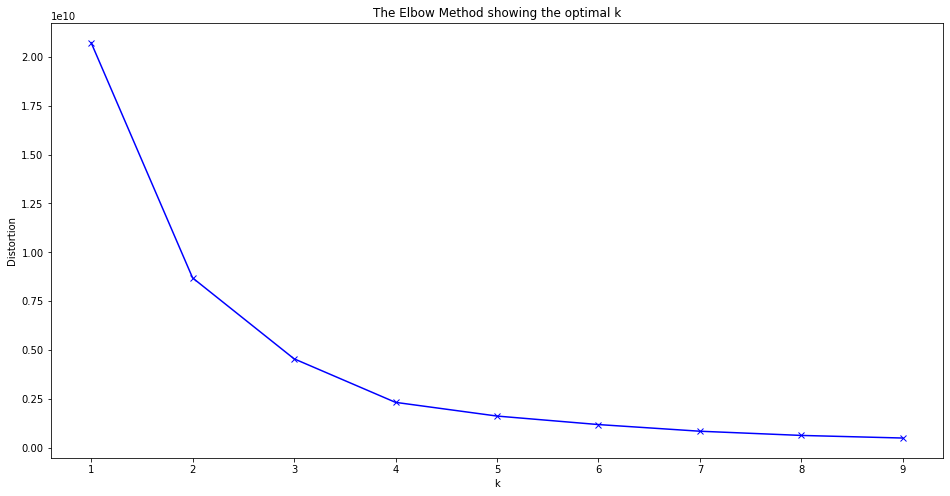

In [52]:
#plot elbow method
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Elbow point is observed to be 4.

In [56]:
#build classifier using four clusters
clf = KMeans(n_clusters = 4).fit(RFM_Frame[features])
RFM_Frame['k_means'] = clf.predict(RFM_Frame[features])
RFM_Frame.head()

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity,k_means
0,JM-15535,2017-12-10,82,2,40.760,7,1
1,CS-11845,2017-12-10,71,3,183.590,6,1
2,SP-20920,2017-12-10,50,1,23.992,2,1
3,AJ-10945,2017-12-10,65,2,648.074,11,1
4,FA-14230,2017-12-10,77,2,1365.480,6,0


In [70]:
#briefly see what cluster 2 data look like
mask = RFM_Frame['k_means']==2
RFM_2 = RFM_Frame.loc[mask]
RFM_2.head()

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity,k_means
89,SV-20365,2017-12-10,81,20,8459.936,73,2
236,TA-21385,2017-12-10,49,4,13716.458,18,2
285,HL-15040,2017-12-10,23,2,10522.550,5,2
312,GT-14635,2017-12-10,36,2,8167.420,6,2
769,SV-20365,2017-12-11,82,20,8459.936,73,2


In [69]:
#briefly see what cluster 0 data look like
mask = RFM_Frame['k_means']== 0
RFM_0 = RFM_Frame.loc[mask]
RFM_0.head()

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity,k_means
4,FA-14230,2017-12-10,77,2,1365.480,6,0
11,AH-10210,2017-12-10,17,3,2122.460,16,0
31,CK-12205,2017-12-10,19,6,1491.022,22,0
35,AJ-10795,2017-12-10,146,4,1295.025,17,0
54,EB-13705,2017-12-10,28,3,965.692,9,0


Using RFM to do feature engineering, we can segmenting customers, which is quite popularmethod in machine learning. The reasoning behind it is straight-foward, a customer who bought something in the past few days is more likely to make another purchase than those who do not buy anyhing in the past year.

By using 'Recency', 'Frequency', 'Value' in kmeans elbow plot, we found that n_clustess =4 is the elbow point. 

We then use n_clusters = 4 to train the model, and assign the cluster label. However, we don't know the true label for each customer, no evaluation can be performed. 

By looking at cluster 0 and 2, we can infer that cluster 2 represents those who have a higher frequency and values. Four clusters are assigned to each customer, suggesting that four levels of frequency and values can be categorized. Thie larger value of the cluster, meaning the more consumption of the customer. By this clustering, we can infer that those who bough things with more values are more likely to make another purchase in the future. 